In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
%matplotlib widget 
# use one of the two below if you are using jupyter notebook 
# %matplotlib inline 
# %matplotlib notebook

### Simple Aperture Photometry and Pre-search Data Conditioning Simple Aperture Photometry
In aperture photometry, we sum the flux of several pixels belonging to the chosen aperture to produce a single flux value for our star. Before performing this operation, we must ensure that the background flux (e.g., scattered or reflected light by the atmosphere) is subtracted from the pixels in the aperture. This task is accomplished by computing the average background value per pixel using a different aperture. 

In the *TASTE dataset*, the aperture comprised all the pixels within the aperture radius from the star's centroid, while the background was computed on an annulus around the star. For TESS, the aperture and background pixels are selected within the available pixels in the Target Pixel file using a different algorithm. Still, aperture photometry is computed precisely in the same way. In the TESS dataset, the name **Simple Aperture Photometry (SAP)** identifies the aperture photometry.


**Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP)** flux involves the same aperture photometry derived from the <u>Target Pixel file (TPf)</u>, but it also includes the <u>removal of long-term trends and instrumental biases</u> using **Co-trending Basis Vectors (CBVs)**. 
**CBVs** are <u>sets of systematic trends</u> found in the overall flux data and are available for every operational sector of the mission. They are generated by the TESS pipeline through Principal Component Analysis to help reduce systematic artifacts in the target light curves. If users of TESS data notice ongoing systematic issues in their light curves, they can use CBVs to apply manual photometric corrections that are more specifically aligned with their scientific objectives.

PDCSAP flux is usually cleaner data than SAP flux and has fewer systematic trends. However, in some cases, the correction may not be successful, see, for example, figure A1 in Appendix A of Nardiello et al. 2022. Generally, checking the outcome of automatic corrections made by general-purpose pipelines is always a good practice.

Many of the algorithms used by the TESS team have been developed for the Kepler mission, including the Co-trending Basis Vectors correction.

In [53]:
sector49_tpf = 'tess2022057073128-s0049-0000000198108326-0221-s_tp.fits'
sector49_lcf = 'tess2022057073128-s0049-0000000198108326-0221-s_lc.fits'

sector23_tpf = 'tess2020078014623-s0023-0000000198108326-0177-s_tp.fits'
sector23_lcf = 'tess2020078014623-s0023-0000000198108326-0177-s_lc.fits'

sector50_tpf = 'tess2022085151738-s0050-0000000198108326-0222-s_tp.fits'
sector50_lcf = 'tess2022085151738-s0050-0000000198108326-0222-s_lc.fits'

sector76_tpf = 'tess2024058030222-s0076-0000000198108326-0271-s_tp.fits'
sector76_lcf = 'tess2024058030222-s0076-0000000198108326-0271-s_lc.fits'

sector77_tpf = 'tess2024085201119-s0077-0000000198108326-0272-s_tp.fits'
sector77_lcf = 'tess2024085201119-s0077-0000000198108326-0272-s_lc.fits'


fits.info(sector50_lcf)

Filename: tess2022085151738-s0050-0000000198108326-0222-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18896R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


Compared with the **TPf*8, we have a **smaller number of HDUs**

* No. 0 (Primary): This HDU contains meta-data related to the entire file.

* No. 1 (Lightcurve): This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images.

* No. 2 (Aperture): This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing. This is the same as the target pixel file.
____________

По сравнению с **файлом целевых пикселей (TPF)**, здесь **меньше HDU**.

* № 0 (Основной): Этот HDU содержит метаданные, относящиеся ко всему файлу.
* № 1 (Кривая блеска): Этот HDU включает бинарную таблицу с 11 столбцами, содержащими временной ряд скалярных значений или изображений.
* № 2 (Апертура): Этот HDU представляет изображение, описывающее каждый пиксель и его использование в пайплайне TESS во время обработки данных, аналогично файлу целевых пикселей.

The extracted lightcurves are available in the **second HDU, called LIGHTCURVE**. 

We can see from the associated information that the HDU contains a Binary Table (BinTable) with 20 columns (the data of interest) and 19279 rows, each one corresponding to a cadence (exposure). 

**HDU APERTURE** reports the same information about the aperture in the **TPf**. This information can be used to check if the aperture and background masks used to compute the aperture photometry are the same as those recorded in the TPf.

We can now open the file and check the content of the second HDU (number 1, starting from 0 as Python convention) using the columns method.

In [54]:
lchdu = fits.open(sector49_lcf)
lchdu[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

In the case of the TPf, some rows ended with the declaration
dim = '(11,11)' (см таргет пиксель файл)

meaning that the information in each row of that specific column was a **matrix with the shape 11x11**. 


In this case, no such specification is listed, meaning that the stored array in each row is a single value, either in 
* unsigned byte B (1 byte), 

* single precision float E (32-bit, 4 bytes), 

* or double precision float D (64-bit, 8 bytes). 

The full list of allowed formats for a Bintable can be found in the document defining the FITS standard or in the AstroPy documentation.

| **Name**         | **Unit**  | **Description**                                      |
|------------------|-----------|------------------------------------------------------|
| `TIME`           | Days      | BJD - 2457000 (BTJD)                                 |
| `SAP_FLUX`       | e–/s      | Simple aperture photometry light curve.              |
| `SAP_FLUX_ERR`   | e–/s      | 1-σ uncertainty of the SAP light curve.              |
| `PDCSAP_FLUX`    | e–/s      | Corrected SAP light curve.                           |
| `PDCSAP_FLUX_ERR`| e–/s      | 1-σ uncertainty of the PDC corrected SAP light curve.|
| `QUALITY`        | Bit field | Quality flags, as bitmask.                           |

In [55]:
bjd_tdb = lchdu[1].data['TIME'] + lchdu[1].header['BJDREFI'] +  lchdu[1].header['BJDREFF']
sap_flux = lchdu[1].data['SAP_FLUX']
sap_flux_error = lchdu[1].data['SAP_FLUX_ERR']
pdcsap_flux = lchdu[1].data['PDCSAP_FLUX']
pdcsap_flux_error = lchdu[1].data['PDCSAP_FLUX_ERR']
quality_bitmask = lchdu[1].data['QUALITY']

Concerning the time of each exposure, from the comment in the column definition, we can see that an offset has been removed from each time stamp. 
**This standard is usually referred to as Barycentric TESS Julian Date.**

The documentation explains how to access the constant's value through the header of the fits file. 

From the documentation, we also get to know that the constant is divided into two parts, an integer one and a real one:

In [56]:
print('BJDREFI header value:  {1:d}, comment: {0:s}'.format(lchdu[1].header.comments['BJDREFI'], lchdu[1].header['BJDREFI']))
print('BJDREFF header value: {1:f}, comment: {0:s}'.format(lchdu[1].header.comments['BJDREFF'], lchdu[1].header['BJDREFF']))

BJDREFI header value:  2457000, comment: integer part of BTJD reference date
BJDREFF header value: 0.000000, comment: fraction of the day in BTJD reference date


1. Исправление времени прохождения света (Light Travel Time correction) уже включено в указанные значения BJD_TDB. То есть, для него не требуется дополнительной корректировки, как это может быть необходимо в других случаях, например, в данных TASTE 

2. Мы можем получить доступ к массивам данных через атрибуты в соответствующих HDU (Header Data Unit), таких как SAP_FLUX и PDCSAP_FLUX, а также их ошибки и битовую маску качества.

3. Для каждого значения времени экспозиции из данных удаляется определенный сдвиг. Этот стандарт времени называется Барицентрической датой Джулиана (Barycentric TESS Julian Date, BTJD).

4. Документация объясняет, как получить значение этой константы, которая является основой для преобразования из BTJD в более стандартную астрономическую шкалу времени BJD (Barycentric Julian Date). Константа состоит из двух частей: целой части (BJDREFI) и дробной части (BJDREFF), которые хранятся в заголовке файла FITS.

5. Чтобы правильно получить массив времени, необходимо добавлять эту константу к данным времени из файла. Это достигается сложением значений в массиве DATA['TIME'] с соответствующими заголовками BJDREFI и BJDREFF.

In [57]:
#To correctly retrieve the time array, we need to convert BTJD into BJD, 
# i.e., adding back the subtracted constant:
time_array = lchdu[1].data['TIME'] + lchdu[1].header['BJDREFI'] +  lchdu[1].header['BJDREFF']


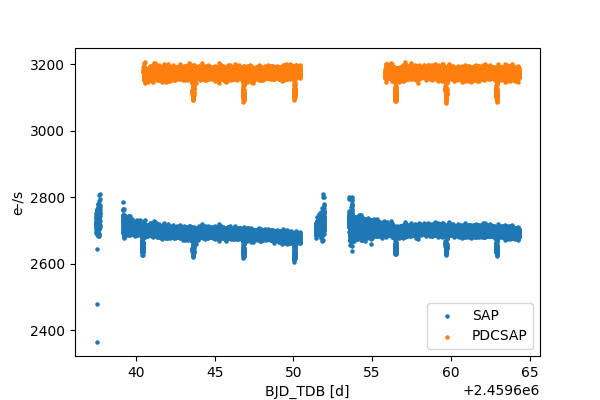

In [58]:
plt.figure(figsize=(6,4))
plt.scatter(time_array, sap_flux, s=5, label='SAP')
plt.scatter(time_array, pdcsap_flux, s=5, label='PDCSAP')
plt.xlabel('BJD_TDB [d]')
plt.ylabel('e-/s')
plt.legend()
plt.show()

In [59]:
print('Number of BJD epochs   :', np.shape(time_array))
print('Number of SAP epochs   :', np.shape(sap_flux))
print('Number of PDCSAP epochs:', np.shape(pdcsap_flux))


Number of BJD epochs   : (19331,)
Number of SAP epochs   : (19331,)
Number of PDCSAP epochs: (19331,)


What's the solution to this inconsistency? 

When checking `pdcsap_flux` elements lacking an SAP counterpart on the plot, they're actually `nan`. _NaN_ (Not a Number) indicates an undefined or unrepresentable value, like dividing zero by zero. You might also encounter _inf_ for infinite. By default, `matplotlib` hides these, though they’re in the array

In [60]:
print('Some elements of PDCSAP:', pdcsap_flux[10:20])

Some elements of PDCSAP: [nan nan nan nan nan nan nan nan nan nan]


In [61]:
finite_selection = np.isfinite(pdcsap_flux)
conservative_selection =  ~(quality_bitmask > 0) & finite_selection


In [49]:
# This is an example of bit selection, it may not apply to your case
flags_to_be_checked = np.array([1,2,3,4,5,6,8,10,13,15])
reference_bitmask_in_decimal_system = 0
for v in flags_to_be_checked:
    reference_bitmask_in_decimal_system += 2**(v-1)

index_example_observation = 3
    
print('Value corresponding to the active flags {0:16d}'.format(reference_bitmask_in_decimal_system))
print('example quality bitmask                 {0:16d}'.format(quality_bitmask[index_example_observation]))
print()
print('binary representation of the selected flags    {0:16d}'.format(int(np.binary_repr(reference_bitmask_in_decimal_system))))
print('binary representation of the selected example  {0:16d}'.format(int(np.binary_repr(quality_bitmask[index_example_observation]))))
print()

print('Are we supposed to exclude this point?  {0:}'.format(np.bitwise_and(quality_bitmask[index_example_observation], reference_bitmask_in_decimal_system)> 0))

# bitwise comparison between the reference value and the quality flag
# each flag must be active in your selection AND active in the 
# at least one flag must be positive in order to exclude the point
selective_selection = ~(np.bitwise_and(quality_bitmask, reference_bitmask_in_decimal_system) > 0) & finite_selection

Value corresponding to the active flags            21183
example quality bitmask                               32

binary representation of the selected flags     101001010111111
binary representation of the selected example            100000

Are we supposed to exclude this point?  True


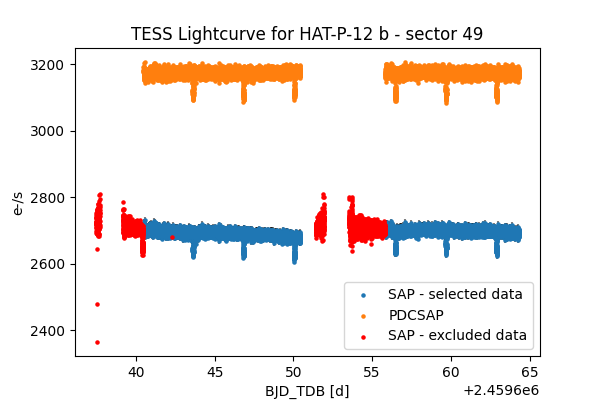

In [62]:
plt.figure(figsize=(6,4))
plt.scatter(time_array[conservative_selection], sap_flux[conservative_selection],
            s=5, label='SAP - selected data')
plt.scatter(time_array, pdcsap_flux, s=5, label='PDCSAP')
plt.scatter(time_array[~conservative_selection], sap_flux[~conservative_selection],
            s=5, c='r', label='SAP - excluded data')
plt.errorbar(time_array[conservative_selection], sap_flux[conservative_selection],
            yerr=sap_flux_error[conservative_selection], fmt=' ', alpha=0.5, 
            ecolor='k', zorder=-1)
plt.xlabel('BJD_TDB [d]')
plt.ylabel('e-/s')
plt.title("TESS Lightcurve for HAT-P-12 b - sector 49", fontsize = 12)

plt.legend()
plt.show()

### Remember

**SAP_FLUX (Simple Aperture Photometry Flux)**: Это измерение светового потока от звезды, полученное путём суммирования света из нескольких пикселей, относящихся к апертуре, выбранной вокруг звезды. Этот метод включает в себя прямое измерение яркости без учёта систематических тенденций и инструментальных эффектов, а также без удаления долгосрочных трендов и систематик.

**PDCSAP_FLUX (Pre-search Data Conditioning SAP Flux)**: Это тот же поток апертурной фотометрии, что и SAP_FLUX, но с дополнительной обработкой. Из него удаляются долгосрочные тренды и систематические погрешности с помощью Котрендинговых базисных векторов (Co-trending Basis Vectors, CBVs). Эти векторы используются для смягчения систематических артефактов в данных кривых блеска, что делает PDCSAP_FLUX обычно более чистыми данными, чем SAP_FLUX, с меньшим количеством систематических тенденций.

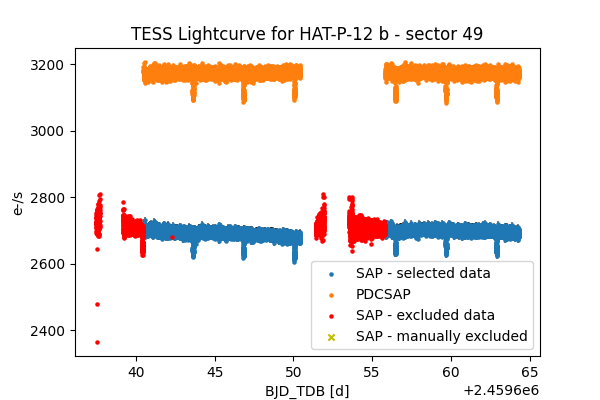

In [63]:
final_selection = conservative_selection 


plt.figure(figsize=(6,4))
plt.scatter(time_array[conservative_selection], sap_flux[conservative_selection],
            s=5, label='SAP - selected data')
plt.scatter(time_array, pdcsap_flux, s=5, label='PDCSAP')


plt.scatter(time_array[~conservative_selection], sap_flux[~conservative_selection],
            s=5, c='r', label='SAP - excluded data')
plt.scatter(time_array[~final_selection & conservative_selection], sap_flux[~final_selection & conservative_selection],
            s=20, c='y', marker='x', label='SAP - manually excluded')
plt.errorbar(time_array[conservative_selection], sap_flux[conservative_selection],
            yerr=sap_flux_error[conservative_selection], fmt=' ', alpha=0.5, 
            ecolor='k', zorder=-1)
plt.xlabel('BJD_TDB [d]')
plt.ylabel('e-/s')
plt.title("TESS Lightcurve for HAT-P-12 b - sector 49", fontsize = 12)

#plt.xlim(2459500.15, 2459500.80)
#plt.ylim(10100, 10300)
plt.legend()
plt.show()

In [64]:
import pickle 

sector44_dictionary = {
    'time': time_array[final_selection],
    'sap_flux': sap_flux[final_selection],
    'sap_flux_error': sap_flux_error[final_selection],
    'pdcsap_flux': sap_flux[final_selection],
    'pdcsap_flux_error': sap_flux_error[final_selection]
}

pickle.dump(sector44_dictionary, 
            open('HATP12_TESS_sector50_lcf_selected.p','wb'))

In [ ]:
# Apparently, the number of points in the PDCSAP is smaller than in the SAP.
# However, if we look at the shape of the two flux arrays, we can see that 
# the number of points is the same. This latter fact makes sense as both
# arrays are plotted against the same array of epochs time_array.

# What is the solution to this apparent inconsistency? 
# If we print the elements of the pdcsap_flux array that do not seem to 
# have only the SAP counterpart in the plot, we can see that these values 
# are all nan, which stands for not a number. A not a number (nan or NaN) 
# is a particular value of a numeric data type that is undefined or 
# unrepresentable, such as the result of zero divided by zero. Depending 
# on the case, you may also get inf, which stands for infinite. By default,
# matplotlib will not display these values, although they are still in your array.